<a href="https://colab.research.google.com/github/Astha-IISERB/Stock_Prediction_using_GNNs/blob/main/RTGCN_for_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Temporal Graph Learning for Stock Prediction**

CS224W Course Project by Xuheng Cai and Benita Wong.

Medium Post: https://medium.com/@benitaw_78759/temporal-graph-learning-for-stock-prediction-58429696f482

*Note: Remember to change runtime to GPU T4 before running this Colab.*

Code for RTGCN framework adapted from: https://github.com/zhengzetao/RTGCN

**Objective:** In this colab, we build a graph neural network that attempts to predict the closing day price of stocks that belong to a particular stock index (NASDAQ) using historical stock price data. Particularly, given relational data amongst stock of an index as well as historical prices of a stock i up to day t, we intend to predict the stock return at day t+1, which can then be used to determine the top 5 and top 10 performing stocks in that index during that day.

### **1. Setup**

This section will set up the environment for running the experiments.

Run the cell below to install PyG.

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Stock_Prediction_MLG

Mounted at /content/drive
/content/drive/MyDrive/Stock_Prediction_MLG


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import RGCNConv, FastRGCNConv
import torch_geometric.transforms as T
import numpy as np

from utils import *

### **2. RTGCN with Different GNN Layers**

In this section, we experiment with incorporating two different types of GNN layers (GCN and GraphSage) into the RTGCN framework.

The class below leverages the **PyG GCNConv** class to implement the GCN layers for RTGCN.

Each GNN layer (except the last) comprises a GCNConv layer, 1D Batch norm, ReLU activation and dropout.

*Structure adapted from CS224W Colab 2 Exercises*

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, num_nodes):
        super(GCN, self).__init__()

        # First layer of GCN
        lst_GCNConv = [GCNConv(in_channels = input_dim, out_channels = hidden_dim)]
        # Hidden layers of GCN
        for i in range(num_layers - 2):
          lst_GCNConv.append(GCNConv(in_channels = hidden_dim, out_channels = hidden_dim))
        # Final layer of GCN
        lst_GCNConv.append(GCNConv(in_channels = hidden_dim, out_channels = output_dim))

        self.convs = torch.nn.ModuleList(lst_GCNConv)
        # normalization
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(num_features = hidden_dim * num_nodes, affine = False) for i in range(num_layers - 1)])
        # dropout to alleviate overfitting
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i in range(len(self.convs) - 1):
          x = self.convs[i].forward(x, adj_t)   # graph convolution
          N,T,V,C =  x.size()   # N: batch size, T: timestep, V: number of nodes, C: number of features
          x = torch.permute(x, (0,2,3,1))
          x = x.view(N, V * C, T)
          x = self.bns[i](x)   # normalization
          x = torch.nn.functional.relu(x)   # activation
          x = torch.nn.functional.dropout(x,self.dropout)   # dropout
          x = x.view(N, V, C, T)
          x = x.permute(0, 3, 1, 2).contiguous()

        out = self.convs[-1].forward(x, adj_t)
        return out

The class below defines the **relational-temporal convolution operator** for RTGCN. It constructs either GCN or GraphSAGE_NN as its relational graph convolution component. It also constructs the temporal convolution layers.

In [5]:
class RTConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dropout=0, num_nodes=171):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        #######################################################
        # Change different GNN layers here:

        # Single layer GCN
        #self.gcn = GCNConv(-1, out_channels)

        # Multi layers GCN (3 layers)
        self.gcn = GCN(-1, int(out_channels*1.5), out_channels, 3, 0.5, num_nodes)
        #######################################################

        # Temporal convolution
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, (kernel_size[0], 1), (stride, 1), padding),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=1, stride=(stride, 1)),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.LeakyReLU(inplace=True,negative_slope=0.2)

    def forward(self, x, A):
        res = self.residual(x) # for processing the residual component
        x = x.permute(0,2,3,1)
        # relational graph convolution
        x = self.gcn(x, A[0].to_sparse().indices())
        x = x.permute(0,3,1,2)
        # temporal convolution and residual connection
        x = self.tcn(x) + res

        return self.relu(x), A

The class below defines the overall **RTGCN model**. It constructs different components of the model, processes the graph, normalizes the data, and passes the inputs through the components.

In [ ]:
class RTGCN(nn.Module):
    def __init__(self, in_channels, market, relation_path):
        super().__init__()

        # load graph
        self.graph = Graph(market=market, relation_path=relation_path)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        relation = torch.tensor(self.graph.relation, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        self.register_buffer('relation', relation)

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))

        self.linear = nn.Linear(self.relation.size(2),1)
        self.rt_gcn_networks = nn.ModuleList((RTConv(in_channels, 8, kernel_size, 2),))

        # initialize parameters for edge importance weighting with "weighted" strategy
        self.edge_importance = nn.ModuleList([nn.Linear(self.relation.size(2),1) for i in self.rt_gcn_networks])

        # fcn for prediction
        self.fcn = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        # data normalization
        N, C, T, V = x.size()   # N: batch size, T: timestep, V: number of nodes, C: number of features
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # relational-temporal graph convolution
        S, M, D = self.relation.size()
        for gcn, importance in zip(self.rt_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * (importance(self.relation.view(S*M, D)).view(S,M)+torch.eye(S).to(device)))

        # global pooling
        x = F.avg_pool2d(x,(x.size(2),1))
        x = x.view(N,-1,1,V)

        # prediction
        x = self.fcn(x)
        x = x.view(x.size(0), x.size(3))

        return x


The macro variables and hyperparameters are defined below.

In [6]:
market = "NIFTY"
relation_path = "NIFTY_relations.npy"
train_data_path = "train_15_eod.npy"
train_price_path = "train_15_price.npy"
train_label_path = "train_15_label.pkl"
test_data_path = "test_15_eod.npy"
test_price_path = "test_15_price.npy"
test_label_path = "test_15_label.pkl"

# hyperparameters
n_epochs = 50
batch_size = 64
in_channels = 4
dropout = 0.5
lr = 0.001
weight_decay = 0.1

# use cuda when available, otherwise modify to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Initialize the model, loss function, and optimizer below.

In [ ]:
model = RTGCN(in_channels, market, relation_path)
model = model.to(device)
loss_func = nn.MSELoss()   # use simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Load the data.

In [ ]:
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(
        dataset=Feeder(train_data_path, train_price_path, train_label_path),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)
data_loader['test'] = torch.utils.data.DataLoader(
        dataset=Feeder(test_data_path, test_price_path, test_label_path),
        batch_size=batch_size,
        shuffle=False)

Define training procedure.

In [ ]:
def train():
    model.train()

    loader = data_loader['train']
    loss_value = []
    for data, closing_price, label in loader:

        data = data[:,[0,1,2,4],:,:].float().to(device)
        closing_price = closing_price.float().to(device)
        label = label.float().to(device)
        # forward
        output = model(data)
        prediction = torch.div(torch.sub(output, closing_price), closing_price)
        loss = loss_func(prediction, label)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statistics
        loss_value.append(loss.data.item())

    return np.mean(loss_value)

Define testing procedure.

In [ ]:
def test(evaluation=True):
    model.eval()
    loader = data_loader['test']
    loss_value = []
    result_frag = []
    label_frag = []

    for data, closing_price, label in loader:
        # get data
        data = data[:,[0,1,2,4],:,:].float().to(device)
        closing_price = closing_price.float().to(device)
        label = label.float().to(device)
        # inference
        with torch.no_grad():
            output = model(data)
            prediction = torch.div(torch.sub(output, closing_price), closing_price)
        result_frag.append(prediction.data.cpu().numpy())
        # get loss
        if evaluation:
            loss = loss_func(prediction, label)
            loss_value.append(loss.item())
            label_frag.append(label.data.cpu().numpy())

    result = np.concatenate(result_frag)
    if evaluation:
        label = np.concatenate(label_frag)
        result = np.delete(result,89, axis=0)
        label = np.delete(label,89, axis=0)
        mae = 0.0
        for i in range(result.shape[0]):
            mae += np.sum(np.absolute(result[i]-label[i]))/len(result[i])
        epoch_mae = mae / result.shape[0]
        epoch_mean_loss = np.mean(loss_value)
        top5_irr = calc_return_ratio(result, label, 5)
        top10_irr = calc_return_ratio(result, label, 10)
        print("MAE:", epoch_mae, "Top-5 return ratio:", top5_irr, "Top-10 return ratio:", top10_irr)

Start training below!

In [ ]:
best_loss = 1e9
for epoch in range(n_epochs):
    # training
    epoch_loss = train()
    print("Epoch:", epoch, "Loss:", epoch_loss)

    # evaluation
    if ((epoch + 1) % 3 == 0) or (epoch + 1 == n_epochs):
        print('Eval epoch: {}'.format(epoch))
        test()

Epoch: 0 Loss: 1.0004026293754578
Epoch: 1 Loss: 1.0001743279005353
Epoch: 2 Loss: 1.0002332423862659
Eval epoch: 2
MAE: 0.99708015 Top-5 return ratio: 1.0760603 Top-10 return ratio: 1.0499468
Epoch: 3 Loss: 1.000280897868307
Epoch: 4 Loss: 0.9999831695305673
Epoch: 5 Loss: 0.9995568300548353
Eval epoch: 5
MAE: 0.9983747 Top-5 return ratio: 1.0409808 Top-10 return ratio: 1.0261271
Epoch: 6 Loss: 0.9991147925979212
Epoch: 7 Loss: 0.9985437706897133
Epoch: 8 Loss: 0.9985450098389074
Eval epoch: 8
MAE: 0.9993738 Top-5 return ratio: 0.98773336 Top-10 return ratio: 1.0983703
Epoch: 9 Loss: 0.9979861535524067
Epoch: 10 Loss: 0.9978571032222948
Epoch: 11 Loss: 0.9980271709592718
Eval epoch: 11
MAE: 0.9981288 Top-5 return ratio: 0.970984 Top-10 return ratio: 1.0824884
Epoch: 12 Loss: 0.9978052691409462
Epoch: 13 Loss: 0.9978064612338418
Epoch: 14 Loss: 0.9979401638633326
Eval epoch: 14
MAE: 0.9979601 Top-5 return ratio: 1.039271 Top-10 return ratio: 1.1071061
Epoch: 15 Loss: 0.9980470036205492

## **3. RTGCN with Heterogenous Layer**

In this section, we experiment with incorporating heterogenous GNN layer (RGCN) into the RTGCN framework.

The class below defines the **relational-temporal convolution operator**, with the relational graph convolution implemented as RGCN using the **PyG FastRGCNConv** class.

In [ ]:
class Hete_RTConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dropout=0, num_relations=None, num_bases=10):
        super().__init__()
        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        # Single layer RGCN
        self.gcn = FastRGCNConv(in_channels, out_channels, num_relations, num_bases=num_bases)

        # Temporal convolution
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, (kernel_size[0], 1), (stride, 1), padding),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=1, stride=(stride, 1)),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.LeakyReLU(inplace=True,negative_slope=0.2)

    def forward(self, x, edge_index, edge_type):
        res = self.residual(x)
        x = x.permute(0,2,3,1)
        A, B, C, D = x.shape
        # relational graph convolution with RGCN
        # performed on each timestep manually, as FastRGCNConv does not support batch processing
        x = torch.cat([self.gcn(x_slice, edge_index, edge_type) for x_slice in x.reshape(A*B, C, D)]).reshape(A, B, C, D*2)
        x = x.permute(0,3,1,2)
        # temporal convolution and residual connection
        x = self.tcn(x) + res

        return self.relu(x)

The class below defines the overall **RTGCN model** with heterogenous GNN layer.

In [ ]:
class Hete_RTGCN(nn.Module):
    def __init__(self, in_channels, market, relation_path):
        super().__init__()

        # load graph
        self.graph = Graph(market=market, relation_path=relation_path)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)

        # process the relations into PyG format
        relation = torch.tensor(self.graph.relation, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        self.register_buffer('relation', relation)
        num_relations = relation.shape[2]
        edge_type_l = []
        edge_index_l = []
        for r in range(num_relations):
          r_edge_index = relation[:,:,r].to_sparse().indices()
          edge_index_l.append(r_edge_index)
          edge_type_l += [r]*r_edge_index.shape[1]
        edge_type = torch.tensor(edge_type_l, dtype=torch.int64, requires_grad=False)
        edge_index = torch.cat(edge_index_l, dim=1).to(torch.int64)
        self.register_buffer('edge_type', edge_type)
        self.register_buffer('edge_index', edge_index)

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))

        self.linear = nn.Linear(self.relation.size(2),1)
        self.rt_gcn_networks = nn.ModuleList((Hete_RTConv(in_channels, 8, kernel_size, 2, num_relations=num_relations),))
        self.fcn = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        # data normalization
        N, C, T, V = x.size()   # N: batch size, T: timestep, V: number of nodes, C: number of features
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # relational-temporal graph convolution
        S, M, D = self.relation.size()
        for gcn in self.rt_gcn_networks:
            x = gcn(x, self.edge_index, self.edge_type)

        # global pooling
        x = F.avg_pool2d(x,(x.size(2),1))
        x = x.view(N,-1,1,V)
        # prediction
        x = self.fcn(x)
        x = x.view(x.size(0), x.size(3))

        return x


Initialize the model, loss function, and optimizer below.

In [ ]:
model = Hete_RTGCN(in_channels, market, relation_path)
model = model.to(device)
loss_func = nn.MSELoss()   # use simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Start training below!

**Please note: Running the following cell takes ~ 2h**. The output from a previous run is shown below if you do not wish to run the following cell.

In [ ]:
best_loss = 1e9
for epoch in range(n_epochs):
    # training
    epoch_loss = train()
    print("Epoch:", epoch, "Loss:", epoch_loss)

    # evaluation
    if ((epoch + 1) % 3 == 0) or (epoch + 1 == n_epochs):
        print('Eval epoch: {}'.format(epoch))
        test()

Epoch: 0 Loss: 1.582308080792427
Epoch: 1 Loss: 0.525695039331913
Epoch: 2 Loss: 0.3112313449382782
Eval epoch: 2
MAE: 0.7177618102931214 Top-5 return ratio: 1.8262145115179003 Top-10 return ratio: 1.848319378838642
Epoch: 3 Loss: 0.217820855230093
Epoch: 4 Loss: 0.16110521405935288
Epoch: 5 Loss: 0.1268840342760086
Eval epoch: 5
MAE: 0.4732254494127463 Top-5 return ratio: 2.0016741978208294 Top-10 return ratio: 1.7351357367952014
Epoch: 6 Loss: 0.10349091216921806
Epoch: 7 Loss: 0.07831972874701024
Epoch: 8 Loss: 0.06368581503629685
Eval epoch: 8
MAE: 0.30687424860228263 Top-5 return ratio: 2.0972962082596496 Top-10 return ratio: 2.14531643185619
Epoch: 9 Loss: 0.05426029562950134
Epoch: 10 Loss: 0.048949962854385375
Epoch: 11 Loss: 0.04513742383569479
Eval epoch: 11
MAE: 0.22759400444313388 Top-5 return ratio: 1.7188971625815619 Top-10 return ratio: 1.8676772544888085
Epoch: 12 Loss: 0.04300419352948666
Epoch: 13 Loss: 0.03929341062903404
Epoch: 14 Loss: 0.0379714822396636
Eval epoch

For detailed descriptions of the model and analysis of the results, please refer to our medium post!

## **4. Code to generate select figures in Medium**


This section documents the codes used to generate the figures utilised in our medium post.

In [7]:
import random
import networkx as nx
import pickle
import matplotlib.pyplot as plt
random.seed(123)

**Generating Fig. 1 using networkx.** Each stock in NASDAQ index corresponds to a node in the graph above, with different relations (sans self loops) between  stock counters corresponding to different colored edges.

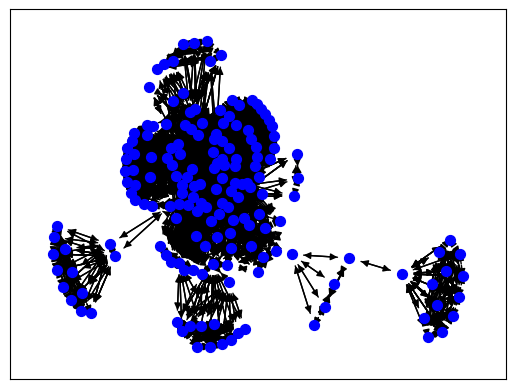

In [8]:
G = nx.DiGraph()
edge_lst = []

graph = Graph(market=market, relation_path=relation_path)
relation = torch.tensor(graph.relation, dtype=torch.float32, requires_grad=False)
num_relations = relation.shape[2]

for r in range(num_relations):
    adj = relation[:,:,r].numpy()
    lst = []

    # get all edges where value != 0
    edges = np.argwhere(adj != 0)

    for (u,v) in edges:
        if u == v:
            continue
        G.add_edge(u, v)
        lst.append((u, v))

    if lst:
        edge_lst.append(lst)

pos = nx.kamada_kawai_layout(G)

for lst in edge_lst:
    nx.draw_networkx_edges(G, pos, edgelist=lst)

nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=50)

In [10]:
G = nx.DiGraph()
edge_lst = []

graph = Graph(market=market, relation_path=relation_path)
relation = torch.tensor(graph.relation, dtype=torch.float32, requires_grad=False)
num_relations = relation.shape[2]

In [11]:
r_edge_index = np.array(relation[:,:,0].to_sparse().indices()).tolist()

In [20]:
for idx in r_edge_index:
  print(idx)
  print(len(idx))
  print(idx[0])
  print(idx[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 

In [28]:
row = r_edge_index[0]
col = r_edge_index[1]

edge_index = list(zip(row, col))
print(edge_index)
print(len(edge_index))
print(edge_index[1][1])

[(0, 0), (0, 2), (0, 16), (0, 18), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 35), (0, 36), (0, 38), (0, 55), (0, 67), (0, 68), (0, 69), (0, 75), (0, 76), (0, 77), (0, 79), (0, 82), (0, 84), (0, 96), (0, 98), (0, 100), (0, 104), (0, 107), (0, 109), (0, 112), (0, 126), (0, 130), (0, 134), (0, 138), (0, 139), (0, 141), (0, 163), (0, 169), (1, 1), (1, 6), (1, 12), (1, 14), (1, 25), (1, 26), (1, 29), (1, 31), (1, 37), (1, 41), (1, 44), (1, 46), (1, 59), (1, 64), (1, 65), (1, 83), (1, 88), (1, 89), (1, 95), (1, 99), (1, 131), (1, 136), (1, 142), (1, 144), (1, 146), (1, 147), (1, 156), (2, 0), (2, 2), (2, 16), (2, 18), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 35), (2, 36), (2, 38), (2, 55), (2, 67), (2, 68), (2, 69), (2, 75), (2, 76), (2, 77), (2, 79), (2, 82), (2, 84), (2, 96), (2, 98), (2, 100), (2, 104), (2, 107), (2, 109), (2, 112), (2, 126), (2, 130), (2, 134), (2, 138), (2, 139), (2, 141), (2, 163), (2, 169), (3, 3), (3, 9), (3, 10), (3, 13), (3, 45), (3, 63), (3, 71), (3

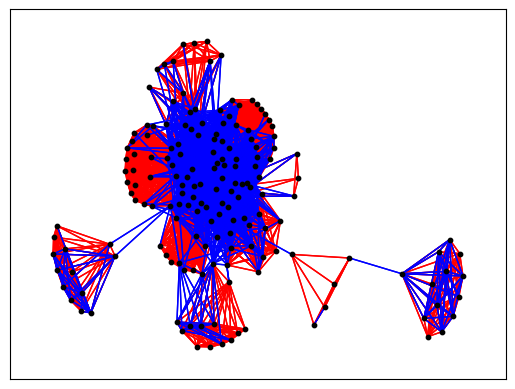

In [40]:
G = nx.Graph()
edge_lst = []

graph = Graph(market=market, relation_path=relation_path)
relation = torch.tensor(graph.relation, dtype=torch.float32, requires_grad=False)
num_relations = relation.shape[2]

for r in range(num_relations):
    lst = []

    # get COO indices
    indices = relation[:, :, r].to_sparse().indices()   # shape = (2, N)
    rows = indices[0].tolist()
    cols = indices[1].tolist()

    # iterate over edges
    for u, v in zip(rows, cols):
        if u == v:       # skip self-loops
            continue

        G.add_edge(u, v, color='r')
        lst.append((u, v))

    edge_lst.append(lst)

pos = nx.kamada_kawai_layout(G)
#pos = nx.circular_layout(G)

#nx.draw_networkx_edges(G, pos, edgelist=edge_lst[0], edge_color = 'tab:blue')

color = ['red', 'blue']
i = 0
for lst in edge_lst:
    nx.draw_networkx_edges(G, pos, edgelist=lst, edge_color = color[i])
    i = i+1

'''
pos = nx.arf_layout(G)
count = 0
for lst in edge_lst:
  nx.draw_networkx_edges(G, pos, edgelist = lst, edge_color = (random.random(), random.random(), random.random()))
'''
nx.draw_networkx_nodes(G, pos, node_color = 'black', node_size = 10)


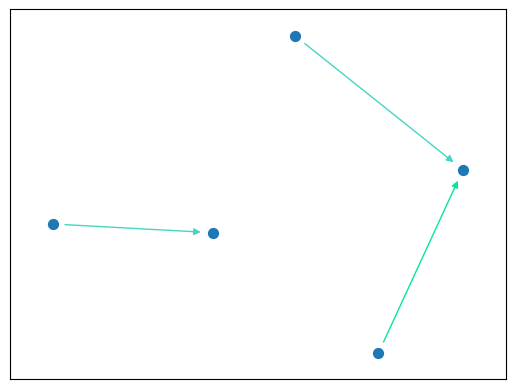

In [32]:
G = nx.DiGraph()
edge_lst = []

graph = Graph(market=market, relation_path=relation_path)
relation = torch.tensor(graph.relation, dtype=torch.float32, requires_grad=False)
num_relations = relation.shape[2]

for r in range(num_relations):
    lst = []
    temp_count = 0
    r_edge_index = np.array(relation[:,:,r].to_sparse().indices()).tolist()
    for idx in r_edge_index:
      if len(idx) < 2 or idx[0] == idx[1]:
        continue
      else:
        G.add_edge(idx[0], idx[1], color = 'r')
        lst.append((idx[0], idx[1]))
    if lst:
      edge_lst.append(lst)

pos = nx.arf_layout(G)
count = 0
for lst in edge_lst:
  nx.draw_networkx_edges(G, pos, edgelist = lst, edge_color = (random.random(), random.random(), random.random()))

nx.draw_networkx_nodes(G, pos, node_color = 'tab:blue', node_size = 50)


**Generating Fig. 4, by logging the daily Top-5 stock prediction over the duration of the test period.** Note: To ensure reproducibility of figures generated (given variance of model results across runs), we created .pkl object which stores a dictionary containing the Top-5 and Top-10 daily stock predictions derived from GCN-3, GraphSage3_Mean and GraphSage3_Max trained models saved from previous experiments.

In [ ]:
!gdown 1R_EQwZucJFkTVCWl8Dw4KsfK_CTfb5fk

Downloading...
From: https://drive.google.com/uc?id=1R_EQwZucJFkTVCWl8Dw4KsfK_CTfb5fk
To: /content/storage_new.pkl
100% 397k/397k [00:00<00:00, 124MB/s]


In [ ]:
storage = pickle.load(open("storage_new.pkl", "rb"))

Generating Fig. 4a

In [ ]:
def find_similarity(sim_lst, lst1, lst2):
  for i in range(len(lst1)):
    set_val = set()
    for j in range(len(lst1[i])):
      set_val.add(lst1[i][j][0])
      set_val.add(lst2[i][j][0])
    sim_lst.append(10 - len(set_val))

def plot_similarity(similarity, title, color = "blue"):
  proportionsimilarity_5 = [i/5 for i in similarity]

  plt.figure(figsize=(10,5))
  width = 0.6
  plt.bar([i for i in range(len(similarity))], proportionsimilarity_5 , width, color = color)
  plt.ylim(0,1)

  plt.xlabel('Days since 03/02/2020')
  plt.ylabel('Proportion similarity (Top-5) stock picks)')
  plt.title(title)

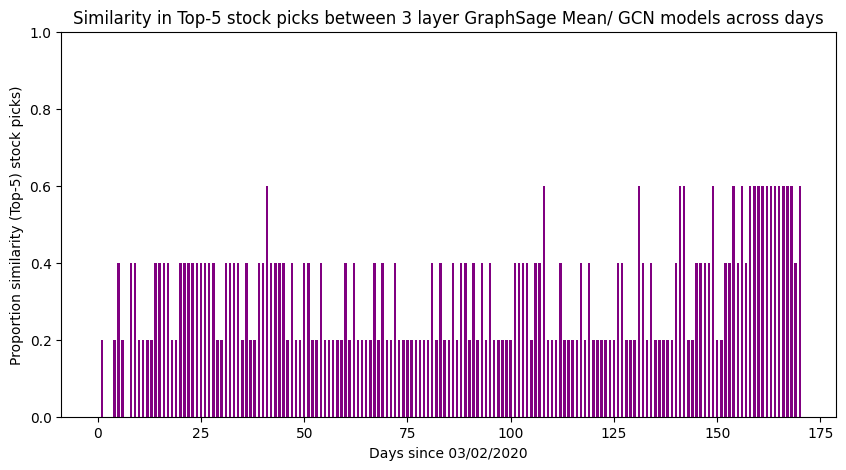

In [ ]:
similarity = []
mean_lst = storage["GraphSage3_Mean"][0]
gcn_lst = storage["GCN_3"][0]

find_similarity(similarity, mean_lst, gcn_lst)
plot_similarity(similarity, "Similarity in Top-5 stock picks between 3 layer GraphSage Mean/ GCN models across days", "purple")

Generating Fig. 4b

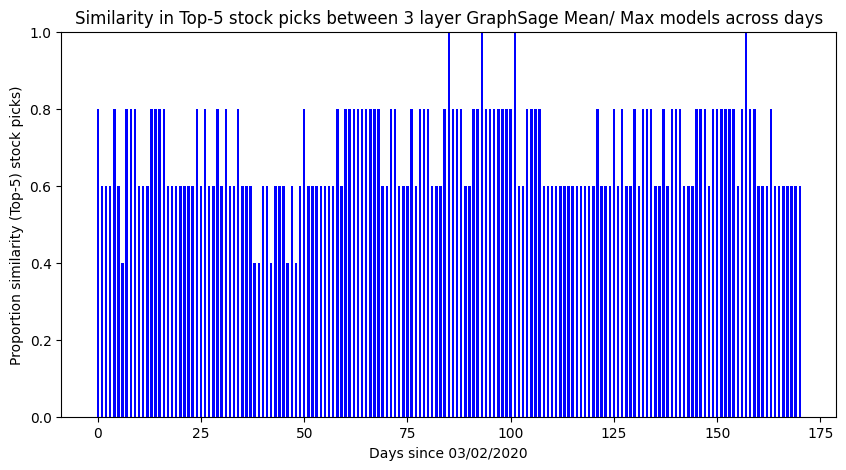

In [ ]:
similarity = []
mean_lst = storage["GraphSage3_Mean"][0]
max_lst = storage["GraphSage3_Max"][0]

mean_lst = storage["GraphSage3_Mean"][0]
gcn_lst = storage["GCN_3"][0]

find_similarity(similarity, mean_lst, max_lst)
plot_similarity(similarity, "Similarity in Top-5 stock picks between 3 layer GraphSage Mean/ Max models across days")


**Generating Fig. 5, distribution of the number of days each stock was part of the Top-5 stock picks derived from the respective models.**

In [ ]:
def update_dist(lst, dist):
  for day in lst:
    for pred in day:
      if pred[0] not in dist:
        dist[pred[0]] = 0
      dist[pred[0]] += 1

most_common_stock_gcn = dict()
gcn_lst = storage["GCN_3"][0]
update_dist(gcn_lst, most_common_stock_gcn)

most_common_stock_mean = dict()
mean_lst = storage["GraphSage3_Mean"][0]
update_dist(mean_lst, most_common_stock_mean)

most_common_stock_max = dict()
max_lst = storage["GraphSage3_Max"][0]
update_dist(max_lst, most_common_stock_max)

In [ ]:
def plot_dist(dist, color = "blue"):
  plt.figure(figsize=(10,5))
  plt.bar(dist.keys(), dist.values(),width = 1, color = color)
  plt.xlabel('Stock index')
  plt.ylabel('Number of days in Top-5 pick')
  plt.title("Distribution of the number of days each stock was part of the top 5 pick")

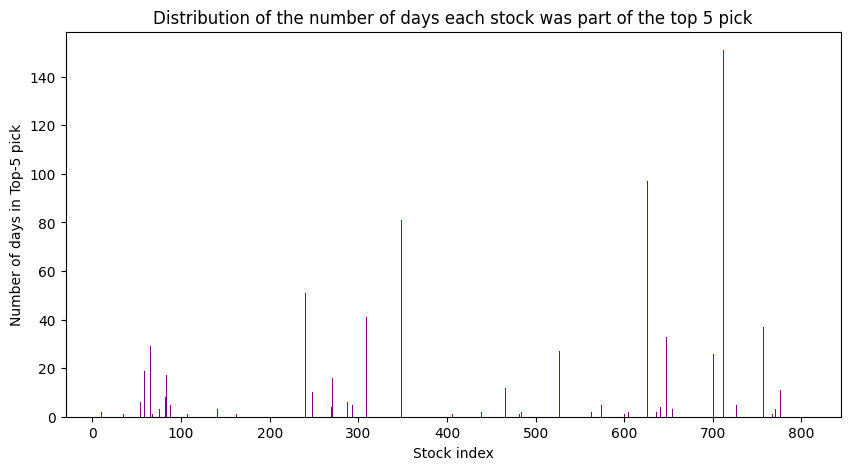

In [ ]:
plot_dist(most_common_stock_gcn, color = "purple")

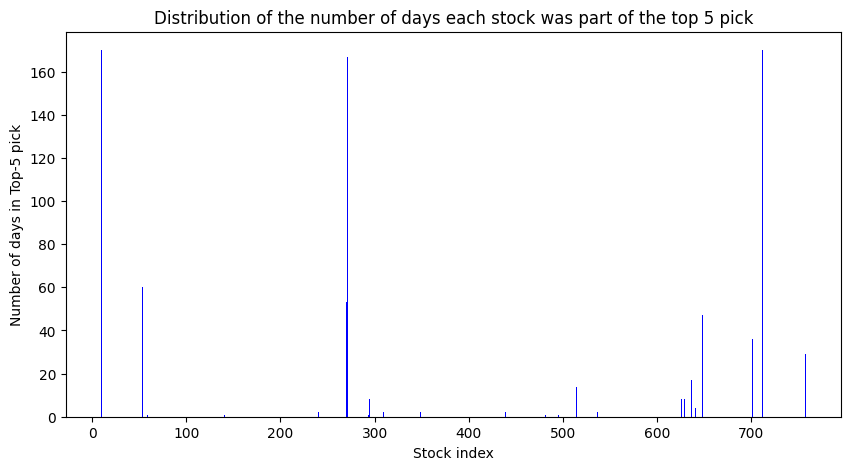

In [ ]:
plot_dist(most_common_stock_mean)

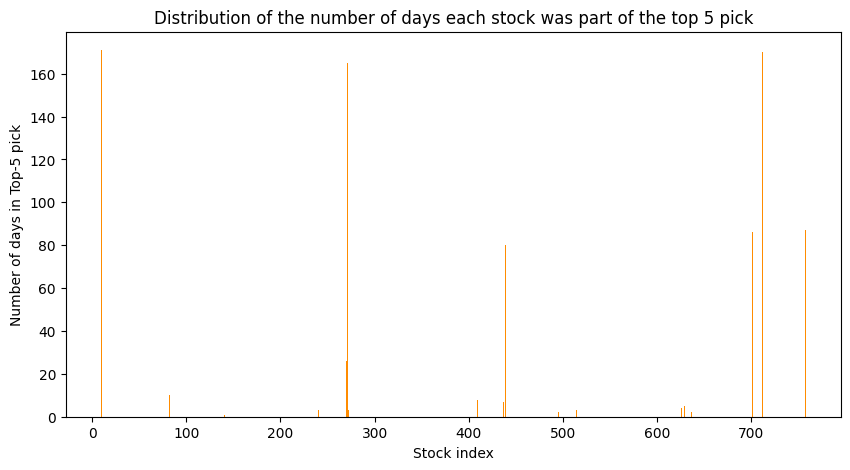

In [ ]:
plot_dist(most_common_stock_max, "darkorange")

**Calculating Ground Truth values**: Best attainable Top-5 IRR and Top-10 IRR + corresponding stock picks, assuming perfect prediction.

In [ ]:
def calc_return_ratio2(label, k, lst):
    bt_k = 1.0
    for i in range(label.shape[0]):
      rank_pre = np.argsort(label[i])

      pre_topk = set()
      return_ration_topk = 0
      for j in range(1, label.shape[1] + 1):
          cur_rank = rank_pre[-1 * j]
          if len(pre_topk) < k:
              pre_topk.add((cur_rank, label[i][cur_rank], label[i][cur_rank]))
              return_ration_topk += label[i][cur_rank]

      return_ration_topk /= k
      bt_k += return_ration_topk
      lst.append(list(pre_topk))
    return bt_k

def ground_truth_values(lst_5, lst_10, evaluation=True):
    loader = data_loader['test']
    label_frag = []

    for data, closing_price, label in loader:
        label = label.float().to(device)
        if evaluation:
            label_frag.append(label.data.cpu().numpy())

    if evaluation:
        label = np.concatenate(label_frag)
        label = np.delete(label,89, axis=0)
        top5_irr = calc_return_ratio2(label, 5, lst_5)
        top10_irr = calc_return_ratio2(label, 10, lst_10)
        print("Top-5 Best return ratio:", top5_irr, "Top-10 Best return ratio:", top10_irr)

ground_truth_5 = []
ground_truth_10 = []
ground_truth_values(ground_truth_5, ground_truth_10)
most_common_stock_truth = dict()
update_dist(ground_truth_5, most_common_stock_truth)

Top-5 Best return ratio: 26.35850911848247 Top-10 Best return ratio: 20.91777562331408


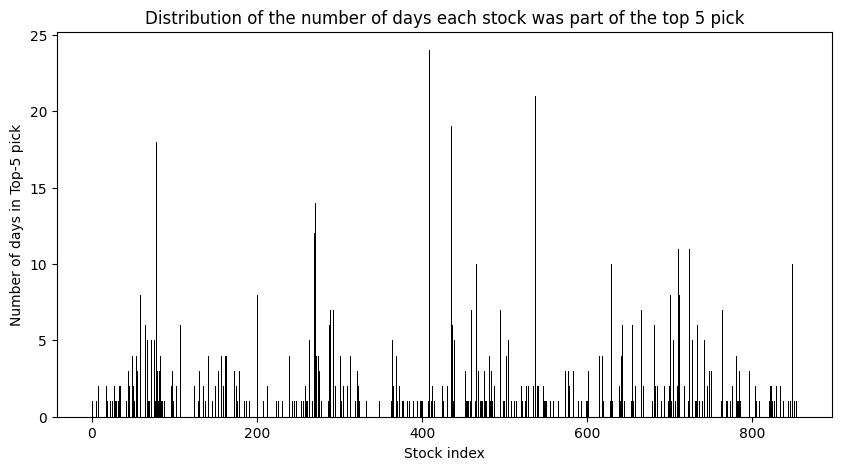

In [ ]:
plot_dist(most_common_stock_truth, "black")

**Generating Fig. 6: Similarity in Top-5 stock picks between 3 layer GCN/ GraphSage Mean and ground truth Top-5 picks across days.**

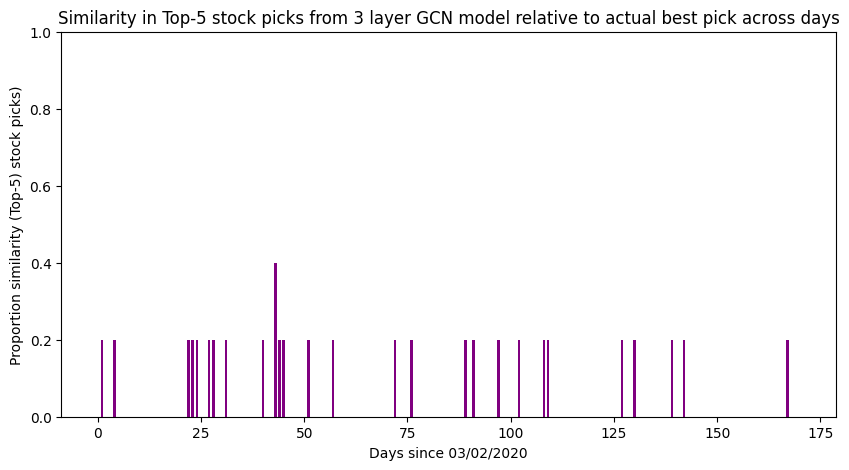

In [ ]:
similarity_truth_gcn = []
gcn_lst = storage["GCN_3"][0]

find_similarity(similarity_truth_gcn, gcn_lst, ground_truth_5)
plot_similarity(similarity_truth_gcn,
                "Similarity in Top-5 stock picks from 3 layer GCN model relative to actual best pick across days",
                color = "purple")


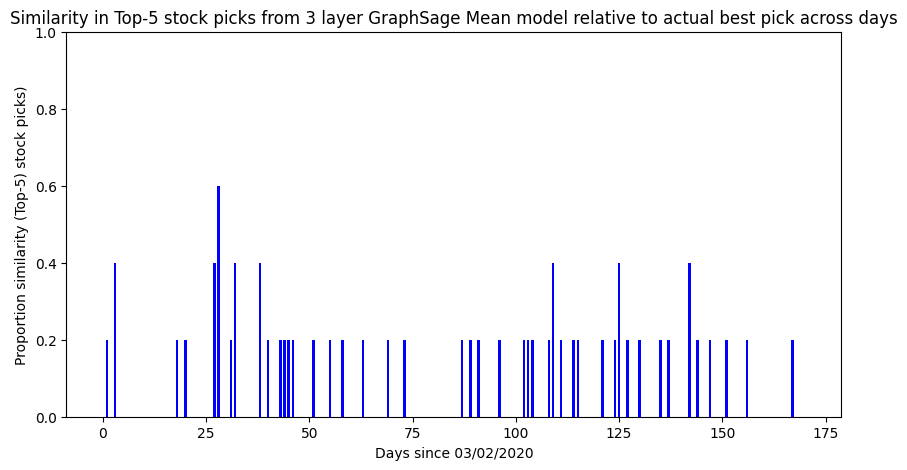

In [ ]:
similarity_truth_mean = []
mean_lst = storage["GraphSage3_Mean"][0]

find_similarity(similarity_truth_mean, mean_lst, ground_truth_5)
plot_similarity(similarity_truth_mean,
                "Similarity in Top-5 stock picks from 3 layer GraphSage Mean model relative to actual best pick across days")
